In [71]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

import astropy
from astroquery.gaia import Gaia


In [2]:
def extract_dl_ind(
    datalink_dict,
    key,
    figsize=[15, 5],
    fontsize=12,
    linewidth=2,
    show_legend=True,
    show_grid=True,
):
    ""
    "Extract individual DataLink products and export them to an Astropy Table"
    ""
    dl_out = datalink_dict[key][0].to_table()
    if "time" in dl_out.keys():
        plot_e_phot(
            dl_out,
            colours=["green", "red", "blue"],
            title="Epoch photometry",
            fontsize=fontsize,
            show_legend=show_legend,
            show_grid=show_grid,
            figsize=figsize,
        )
    if "wavelength" in dl_out.keys():
        if len(dl_out) == 343:
            title = "XP Sampled"
        if len(dl_out) == 2401:
            title = "RVS"
        plot_sampled_spec(
            dl_out,
            color="blue",
            title=title,
            fontsize=fontsize,
            show_legend=False,
            show_grid=show_grid,
            linewidth=linewidth,
            legend="",
            figsize=figsize,
        )
    return dl_out


def plot_e_phot(
    inp_table,
    colours=["green", "red", "blue"],
    title="Epoch photometry",
    fontsize=12,
    show_legend=True,
    show_grid=True,
    figsize=[15, 5],
):
    ""
    "Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    fig = plt.figure(figsize=figsize)
    xlabel = f'JD date [{inp_table["time"].unit}]'
    ylabel = f'magnitude [{inp_table["mag"].unit}]'
    gbands = ["G", "RP", "BP"]
    colours = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table["band"] == band]
        plt.plot(
            phot_set["time"], phot_set["mag"], "o", label=band, color=next(colours)
        )
    make_canvas(
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fontsize=fontsize,
        show_legend=show_legend,
        show_grid=show_grid,
    )
    plt.show()


def plot_sampled_spec(
    inp_table,
    color="blue",
    title="",
    fontsize=14,
    show_legend=True,
    show_grid=True,
    linewidth=2,
    legend="",
    figsize=[12, 4],
    show_plot=True,
):
    ""
    "RVS & XP sampled spectrum plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    if show_plot:
        fig = plt.figure(figsize=figsize)
    xlabel = f'Wavelength [{inp_table["wavelength"].unit}]'
    ylabel = f'Flux [{inp_table["flux"].unit}]'
    plt.plot(
        inp_table["wavelength"],
        inp_table["flux"],
        "-",
        linewidth=linewidth,
        label=legend,
    )
    make_canvas(
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fontsize=fontsize,
        show_legend=show_legend,
        show_grid=show_grid,
    )
    if show_plot:
        plt.show()


def make_canvas(
    title="", xlabel="", ylabel="", show_grid=False, show_legend=False, fontsize=12
):
    ""
    "Create generic canvas for plots"
    ""
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize=fontsize * 0.75)


In [64]:
query = f"SELECT TOP 5000 source_id, pf, p1_o, p2_o, epoch_g, epoch_bp, epoch_rp, type_best_classification, type2_best_sub_classification, mode_best_classification, multi_mode_best_classification \
FROM gaiadr3.vari_cepheid"

job = Gaia.launch_job_async(query)
results = job.get_results()
print(f"Table size (rows): {len(results)}")
results


INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 5000


SOURCE_ID,pf,p1_o,p2_o,epoch_g,epoch_bp,epoch_rp,type_best_classification,type2_best_sub_classification,mode_best_classification,multi_mode_best_classification
,d,d,d,d,d,d,,,,
int64,float64,float64,float64,float64,float64,float64,object,object,object,object
4658032774371311104,6.531933448066952,--,--,1678.1870203804253,1678.5075162218338,1678.1723167285013,DCEP,,FUNDAMENTAL,
4658035626229427456,--,1.178929654547512,--,1692.479882084207,1692.401863121036,1693.5008926595306,DCEP,,FIRST_OVERTONE,
4658036274856153856,--,2.138627783751226,--,1690.08182188946,1690.0822841770398,1691.2819220354038,DCEP,,FIRST_OVERTONE,
4658036828819820800,--,2.6594452248374734,--,1689.3442967248977,1689.2990047955784,1689.4386558874917,DCEP,,FIRST_OVERTONE,
4658039710832195200,2.9115728866339894,--,--,1689.3438208425525,1689.3678185530746,1689.3823540733295,DCEP,,FUNDAMENTAL,
4658040745829467392,7.809231351961235,--,--,1677.4912448231312,1677.4202228331949,1677.5538663009906,DCEP,,FUNDAMENTAL,
4658041222673354112,--,0.7229215717472446,--,1694.2944395132968,1694.3165545951044,1694.268012629557,DCEP,,FIRST_OVERTONE,
4658041707905510912,4.166964178709102,--,--,1687.4246302371273,1687.4220398628775,1687.5508882353658,DCEP,,FUNDAMENTAL,


In [3]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


In [87]:
retrieval_type = "EPOCH_PHOTOMETRY"  # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = "INDIVIDUAL"  # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release = "Gaia DR3"  # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink = Gaia.load_data(
    ids=results["SOURCE_ID"],
    # ids="4658032774371311104",
    data_release=data_release,
    retrieval_type=retrieval_type,
    data_structure=data_structure,
    verbose=False,
    output_file=None,
    format="csv",
)
dl_keys = [inp for inp in datalink.keys()]
dl_keys.sort()

# print()
# print(f"The following Datalink products have been downloaded:")
# for dl_key in dl_keys:
#    print(f" * {dl_key}")


In [88]:
dl_keys

['EPOCH_PHOTOMETRY-Gaia DR3 1208200864738741376.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1439705992904534784.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1452625254531322752.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1454784317416279168.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1454784523573570816.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 174489098011145216.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1745947911417207936.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1745948328028740224.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1745948770410643328.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1750217486861133440.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 175811260743708672.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1825428480248517376.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1825437177598003456.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1825453635920313472.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1825559704420479360.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1825560185457084928.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1825583030353257984.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 1825621002188696448.csv',
 'EPOCH_PHOTOMETRY-Gaia DR3 18

In [85]:
dl_keys

['EPOCH_PHOTOMETRY-Gaia DR3 4658032774371311104.csv']

In [91]:
# ID = results["SOURCE_ID"][0]
ID = 4658032774371311104
print(ID)
# Define the period corresponding to the fundamental pulsation mode
period_f = results[results["SOURCE_ID"] == ID]["pf"][0]
# Define the arbitrary start point of the phase, epoch of the maximum of the light curve in the G band
epoch_g = results[results["SOURCE_ID"] == ID]["epoch_g"][0]

dl_key = f"EPOCH_PHOTOMETRY-Gaia DR3 {ID}.csv"  # Temp key, normally use loop
product = datalink[dl_key][0]
product["phase"] = (product["time"] - epoch_g) % period_f

"""
for column in data.select_dtypes(include=["float64"]).columns:
    z_house = np.abs(zscore(data.loc[data["property_type"] == "HOUSE", column]))
    z_apartment = np.abs(zscore(data.loc[data["property_type"] == "APARTMENT", column]))

    # Identify outliers with a z-score greater than 3
    threshold = 3
    z = pd.concat([z_house, z_apartment]).sort_index()
    outliers = data[z > threshold]

    # Print the outliers
    # print(f"{column}: {len(outliers)}")
    data = data.drop(outliers.index)
"""

product


4658032774371311104


source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,phase
str19,str17,str2,float64,float64,float64,float64,float64,str5,str5,int32,str18,float64
4658032774371311104,16537764888457341,G,1695.921219691927,15.999448847735543,7501.829817050232,9.86192625786685,760.68604,false,false,1,375316653866487564,4.670332415367794
4658032774371311104,16541857175741663,G,1695.9952264105095,15.988287516176488,7579.346124373233,23.30601439676042,325.20987,false,false,1,375316653866487564,4.744339133950289
4658032774371311104,18839286032789799,G,1737.5428522916347,15.805833286349124,8966.303439917207,15.315292170943307,585.44775,false,false,524353,375316653866487564,0.568430878606839
4658032774371311104,18843378341045899,G,1737.616866182851,15.808777439479288,8942.02276192912,27.865231767151393,320.9025,false,false,1,375316653866487564,0.642444769823121
4658032774371311104,20745658281104282,G,1772.0184082490973,15.92485710052767,8035.333501803776,23.250256438016915,345.60193,false,false,1,375316653866487564,2.384319595734654
4658032774371311104,20749750571028612,G,1772.0924147580479,15.930326324661875,7994.958558773737,25.426663800116284,314.43207,false,false,1,375316653866487564,2.4583261046852147
4658032774371311104,22228392291136410,G,1798.8327367959178,15.96452243051599,7747.075253162953,16.43529549481871,471.36816,false,false,1,375316653866487564,3.07091435028728
4658032774371311104,24134515409597761,G,1833.3038670346455,15.981291981114541,7628.338468126871,16.156437091997415,472.15475,false,false,1,375316653866487564,4.88237734868023
4658032774371311104,25553827335394321,G,1858.9713784188705,16.034389553560413,7264.252397471787,14.781598783728953,491.43887,false,false,1,375316653866487564,4.422154940637431


4658032774371311104

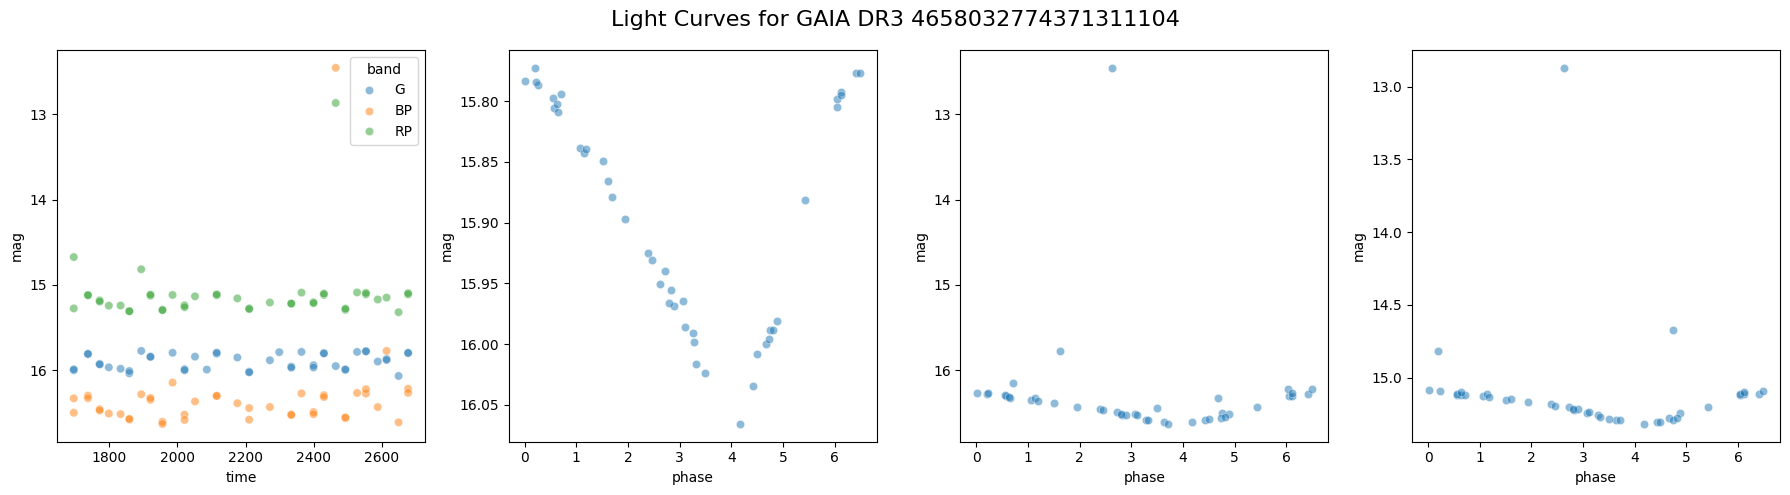

In [83]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

fig.suptitle(f"Light Curves for GAIA DR3 {ID}", fontsize=16)


sns.scatterplot(
    x=product["time"], y=product["mag"], hue=product["band"], alpha=0.5, ax=axs[0]
)
sns.scatterplot(
    x=product[product["band"] == "G"]["phase"],
    y=product[product["band"] == "G"]["mag"],
    alpha=0.5,
    ax=axs[1],
)
sns.scatterplot(
    x=product[product["band"] == "BP"]["phase"],
    y=product[product["band"] == "BP"]["mag"],
    alpha=0.5,
    ax=axs[2],
)
sns.scatterplot(
    x=product[product["band"] == "RP"]["phase"],
    y=product[product["band"] == "RP"]["mag"],
    alpha=0.5,
    ax=axs[3],
)
inv = axs[0].invert_yaxis()
inv = axs[1].invert_yaxis()
inv = axs[2].invert_yaxis()
inv = axs[3].invert_yaxis()

plt.tight_layout()
4658032774371311104


In [ ]:
dl_key = "EPOCH_PHOTOMETRY-Gaia DR3 4911590910260264960.ecsv"

dl_out = extract_dl_ind(
    datalink, dl_key, figsize=[20, 7]
)  # Change the figsize to e.g. figsize=[20,7] to increase the size of the displayed image.
dl_out[0:5]  # Remove the '[0:5]' to display the entire table.


AttributeError: 'str' object has no attribute 'to_table'